<a href="https://colab.research.google.com/github/yeha98555/data-course-sample/blob/main/S5/A6_cf-item-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Item-based collaborative filtering

## 基礎建設

In [8]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [9]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 13:03:53--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.1’

All_Beauty.csv.1    100%[===================>]  14.78M  10.2MB/s    in 1.5s    

2022-01-09 13:03:55 (10.2 MB/s) - ‘All_Beauty.csv.1’ saved [15499476/15499476]

--2022-01-09 13:03:55--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.85M  7.56MB/s    in 1.3s   

In [10]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [11]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [12]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [13]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### 去除重複資料

#### metadata（資料完全一樣的商品）

In [14]:
print('Original Num of metadata: {0}'.format(len(metadata)))
print('Num of duplicated metadata: {0}'.format(metadata.duplicated(subset=['asin', 'title']).sum()))

print('Drop duplicated metadata...')
metadata.drop_duplicates(subset=['asin', 'title'], keep=False, inplace=True)
metadata = metadata.reset_index(drop=True)
print('Current Num of metadata: {0}'.format(len(metadata)))

Original Num of metadata: 32892
Num of duplicated metadata: 404
Drop duplicated metadata...
Current Num of metadata: 32084


## 資料切分

In [15]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

---

保留原始資料，複製一份出來處理。

In [16]:
metadata_tmp = metadata.copy()

ratings_trainings_tmp = ratings_trainings.copy()
ratings_testings_tmp = ratings_testings.copy()

users_testing_tmp = users.copy()

---

## 資料探索

In [11]:
import numpy as np
import matplotlib.pyplot as plt

### 測試資料集

查看測試資料集中的用戶有多少人曾經留下評分過？各留下多少呢？

In [44]:
num_rating_user = ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)]['reviewerID'].nunique()
print('多少人曾留過評分 : {0} ({1}%)'.format(num_rating_user, round(num_rating_user / len(users_testing_tmp)*100)))

多少人曾留過評分 : 38 (7%)


In [45]:
print(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}))
print('這些人平均對多少商品評分: {0}'.format(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}).mean()[0]))

                asin
reviewerID          
A13JU88JAHN72I     1
A16Y7V1CZCWKFV     1
A19503XX7GU6J2     2
A1EY751AUVO5NZ     1
A1PR178735XC70     1
A1SA3N793WT2LM     4
A1TP9JHTIY468V     2
A1UAOE8KO7Q1DZ     1
A1WEFBEJ7OHSVZ     1
A1WSZED2O5MA5T     2
A28E3FNV1BYC94     1
A29834GBB4DOP1     1
A2AAQWBJJTK3E1     1
A2BU6N5956T9NH     1
A2GFPTQ4VWDX96     1
A2IMJV0CQMZLGC     1
A2IOBG1ERS4JP3     1
A2JCBLTLYDPQLW     1
A2M4YSOJZELJ6N     1
A2XFJ8CTY7VDNN     1
A2XY3CJ3ZCAD03     1
A3BE6JK97CYAGA     1
A3BT1WLPENXMD6     3
A3DXW3542E4QUC     1
A3GRQ9WMP4OXFE     1
A3H8Z7JS7XJHJJ     2
A3JEQJCEMX20GI     2
A4IQXCCXDEAKW      2
A7JUHUYLXIUVQ      1
A7Y4ETTLARUGI      1
ACE1ZIOI3U6PY      3
AGRZQOBCF8H87      1
AITF34BGBMVJJ      1
AK7YIZE6ZZ1N9      1
ANR73TPVBCQ9K      1
AQYL4TDY2HU8Z      1
ASGIVOW34XNQS      3
ATJRZUXNWAWIK      1
這些人平均對多少商品評分: 1.394736842105263


如果未曾留下評分，則無法得知喜好，也無法找過去購買的商品推薦類似的，只能用rule-based。
發現有留過評分的占少數，故rule-based方法對整體推薦系統recall影響大。

### 訓練資料集

只推薦在商品資料集中的商品，故下面都只討論有在商品資料集的商品。<br>
會這麼做，主要是因為之後想由商品資料集中取特徵，增加商品相似度計算的準確度。

In [77]:
item_in_medadata = metadata_tmp['asin'].tolist()
print('在商品資料表中有 {0} 個商品'.format(len(item_in_medadata)))

在商品資料表中有 32084 個商品


In [78]:
print('原本評分總筆數: {0}'.format(len(ratings_trainings_tmp)))
print('剔除評分商品為在商品資料集中的評分...')
ratings_trainings_tmp = ratings_trainings_tmp[ratings_trainings_tmp['asin'].isin(item_in_medadata)]
print('剔除後評分總筆數: {0}'.format(len(ratings_trainings_tmp)))

原本評分總筆數: 370752
剔除評分商品為在商品資料表中的評分...
剔除後評分總筆數: 349321


#### 在商品資料集中有多少商品被評分？

In [80]:
item_with_rating = ratings_trainings_tmp.asin.unique().tolist()

In [81]:
item_with_rating_in_metadata = metadata_tmp[metadata_tmp['asin'].isin(item_with_rating)]['asin'].tolist()

In [82]:
# 在現有的商品資料(metadata)中有多少資料未被評分過
print('現有商品資料中有 {0} ({1}%) 評分資料，有 {2} 個商品未有過評分紀錄。'.format(
    len(item_with_rating_in_metadata), 
    round(len(item_with_rating_in_metadata) / len(metadata_tmp['asin']) * 100, 2), 
    len(metadata_tmp['asin']) - len(item_with_rating_in_metadata)))

現有商品資料中有 32078 (99.98%) 評分資料，有 6 個商品未有過評分紀錄。


#### 將重複評分以平均評分取代

In [83]:
# 如果只有一筆就直接填該筆評分，如果有多筆，overall_mean填入評分平均值、overall_lastest填入最近的評分值。
ratings_trainings_unique = ratings_trainings_tmp.groupby(['reviewerID', 'asin']) \
                    .agg(overall=('overall', np.mean)) \
                    .reset_index()
ratings_trainings_unique.head()

,reviewerID,asin,overall
0,A0010876CNE3ILIM9HV0,B01FHDYGQ8,5.0
1,A001170867ZBE9FORRQL,B01B18T01Y,5.0
2,A001170867ZBE9FORRQL,B01FCW88D6,5.0
3,A0028738FYF1SKPPC7B1,B00TZ8XK1E,5.0
4,A0045356A23634W7RI4M,B018H0EJI8,3.0


#### 商品資料集中每個商品大多被多少人評分？

In [84]:
ratings_trainings_item = ratings_trainings_unique.groupby('asin') \
       .agg({'reviewerID':'size', 'overall':'mean'}) \
       .rename(columns={'reviewerID':'rating_count','overall':'mean_score'}) \
       .reset_index().sort_values('rating_count', ascending=False)
ratings_trainings_item.head()

,asin,rating_count,mean_score
446,B000FOI48G,8656,4.394235
566,B000GLRREU,8341,4.405107
2797,B001QY8QXM,4505,4.556049
29048,B01DKQAXC0,4191,4.212718
5460,B006IB5T4W,2789,4.643421


In [85]:
print(ratings_trainings_item['rating_count'])
print('這些商品平均對多少用戶評分: {0}'.format(ratings_trainings_item['rating_count'].mean()))

446      8656
566      8341
2797     4505
29048    4191
5460     2789
         ... 
10299       1
10297       1
21963       1
21966       1
16039       1
Name: rating_count, Length: 32078, dtype: int64
這些商品平均對多少用戶評分 10.587754847559074


但認為只有被一個用戶評分的商品，表示只有一個用戶評分，無法推薦給其他用戶，因為由其他用戶找曾評分商品找到商品後，不會跟這個商品有任何相似，故移除該商品。

In [89]:
print('有被評分的商品總數: {0}'.format(ratings_trainings_unique['asin'].nunique()))
print('剔除只有被一個用戶評分的商品...')
ratings_trainings_item = ratings_trainings_item[ratings_trainings_item['rating_count'] > 1]
print('提除後的商品總數: {0} ({1}%)'.format(
    len(ratings_trainings_item), 
    round(len(ratings_trainings_item) / ratings_trainings_unique['asin'].nunique() *100)))

有被評分的商品總數: 32078
剔除只有被一個用戶評分的商品...
提除後的商品總數: 18742 (58%)


In [90]:
print(ratings_trainings_item['rating_count'])
print('這些商品平均被多少用戶評分: {0}'.format(ratings_trainings_item['rating_count'].mean()))

446      8656
566      8341
2797     4505
29048    4191
5460     2789
         ... 
739         2
5724        2
15204       2
8160        2
4889        2
Name: rating_count, Length: 18742, dtype: int64
這些商品平均被多少用戶評分: 17.409988261658306


In [98]:
ratings_trainings_item['rating_count'].describe()

count    18742.000000
mean        17.409988
std        116.876783
min          2.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       8656.000000
Name: rating_count, dtype: float64

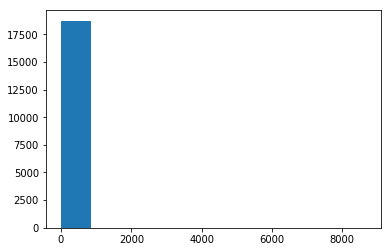

將用戶數超過17個的放大來看...


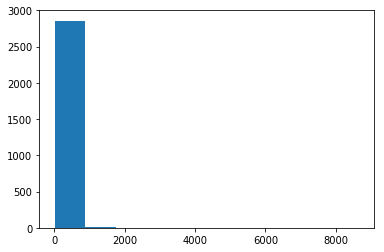

將用戶數超過134個(mean+1*std)的放大來看...


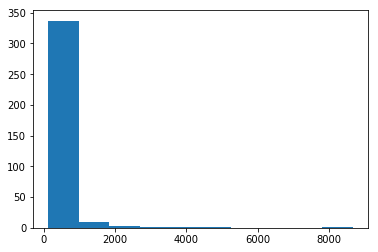

將用戶數超過251個(mean+2*std)的放大來看...


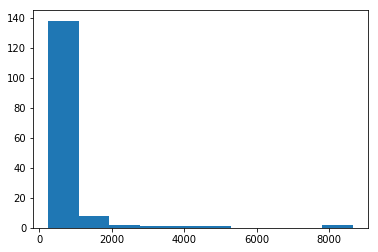

將用戶數超過368個(mean+3*std)的放大來看...


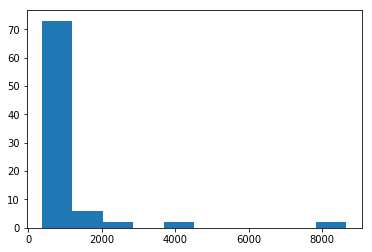

In [102]:
plt.hist(ratings_trainings_item['rating_count'])
plt.show()
print('將用戶數超過17個的放大來看...')
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 17]['rating_count'])
plt.show()
print('將用戶數超過134個(mean+1*std)的放大來看...') # 1*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 134]['rating_count'])
plt.show()
print('將用戶數超過251個(mean+2*std)的放大來看...') # 2*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 251]['rating_count'])
plt.show()
print('將用戶數超過368個(mean+3*std)的放大來看...') # 2*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 368]['rating_count'])
plt.show()

發現商品的用戶評分數落差很大，不知道會不會使得結果不太理想，認為或許能加入更多確定且完整的特徵(如:CATEGORY、title等)。<br>
也思考多少個用戶評分才能夠代表一個商品？認為可留到之後測試。

### 商品資料
根據上份作業的資料探索，將多餘欄位剔除，新增有意義欄位(商品評論數、平均評分、季節性等)，主要是想用於找不到相似用戶時的推薦設計使用，以及在想之後能用於新增商品特徵計算商品相似度。

在此的ratings_trainings都不剔除重複評分，視其各自為獨立購買紀錄，皆列入分析計算。

In [104]:
# 剔除有問題的資料
metadata_tmp = metadata_tmp.drop(metadata[metadata['title'] == ''].index).reset_index(drop=True)

In [109]:
# 剔除評分數小於等於1的商品
metadata_tmp = metadata_tmp[metadata_tmp['asin'].isin(ratings_trainings_item['asin'].unique())]

#### 剔除多餘欄位

In [111]:
metadata_tmp = metadata_tmp.drop(['category', 'tech1', 'fit', 'tech2', 'feature', 'date', 'imageURLHighRes', 'main_cat', 'details'], axis=1)

##### `rank`: 內含有商品類別和其商品於該類別排名，將其拆成`RANK`、`CATEGORY`兩欄位。

In [112]:
metadata_tmp[['RANK', 'CATEGORY']] = metadata_tmp['rank'].str.split(' in ', 1, expand=True)
metadata_tmp['CATEGORY'] = metadata_tmp['CATEGORY'].str.replace(' \(', '')
metadata_tmp['CATEGORY'] = metadata_tmp['CATEGORY'].str.replace('\&amp;', '&')
metadata_tmp['CATEGORY'].value_counts()

Beauty & Personal Care       18574
Grocery & Gourmet Food          25
Health & Household              11
Sports & Outdoors                3
Clothing, Shoes & Jewelry        2
Toys & Games                     1
Tools & Home Improvement         1
Automotive                       1
Name: CATEGORY, dtype: int64

In [113]:
metadata_tmp = metadata_tmp.drop(['rank'], axis=1)

##### `similar_item`: 將其資料html表格轉為asin列表，與`also_buy`、`also_view`合併成`SIMILAR_ITEM`欄位。

In [114]:
from bs4 import BeautifulSoup
metadata['asin'] = metadata['asin'].astype(str)

def convert_similar_table_to_asin_list(html):
#     if (html == ''): return []
    asin_list = []
    
    soup = BeautifulSoup(html)
    
    compare_list = soup.findAll('th', {'class': 'comparison_image_title_cell'})
    for item in compare_list:
        title = item.span.text.strip()
        if (len(metadata[metadata['title'] == title]) > 0):
            asin = metadata[metadata['title'] == title]['asin'].iloc[0]
#             if (not any(asin.str in s for s in asin_list)):  # 去除重複
            asin_list.append(asin)
    
    return asin_list

In [115]:
metadata_tmp['SIMILAR_ITEM'] = metadata_tmp['similar_item'].apply(lambda x: convert_similar_table_to_asin_list(x) if x != ''  else x)

In [116]:
metadata_tmp['SIMILAR'] = [set(list(x)+y+z) for x, y, z in zip(metadata_tmp.SIMILAR_ITEM, metadata_tmp.also_view, metadata_tmp.also_buy)]

In [117]:
metadata_tmp = metadata_tmp.drop(['SIMILAR_ITEM', 'similar_item', 'also_view', 'also_buy'], axis=1)

In [118]:
metadata_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18741 entries, 0 to 32082
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  18741 non-null  object
 1   title        18741 non-null  object
 2   brand        18741 non-null  object
 3   price        18741 non-null  object
 4   asin         18741 non-null  object
 5   imageURL     18741 non-null  object
 6   RANK         18618 non-null  object
 7   CATEGORY     18618 non-null  object
 8   SIMILAR      18741 non-null  object
dtypes: object(9)
memory usage: 1.4+ MB


#### 加入評分
(同用戶對同商品不同時間或不同評分，做為獨立評分(未合併)，分別計入)

In [119]:
rating_mean = ratings_trainings_tmp.groupby('asin')['overall'].mean().round(2).reset_index(name='RATE')
rating_count = pd.DataFrame(ratings_trainings_tmp.asin.value_counts())
rating_count.reset_index(inplace=True)
rating_count.columns = ['asin', 'RATE(COUNT)']
# merge
rating_data = rating_mean.merge(rating_count, on='asin')
metadata_tmp = pd.merge(rating_data, metadata_tmp, left_on="asin", right_on="asin", how='right')

In [120]:
metadata_tmp.fillna({'RATE(COUNT)':0}, inplace=True)

In [121]:
# clear not-used DataFrame
del rating_data

#### 加入季節性
(`None`: 代表商品無季節性)

In [122]:
def MonthToSeason(x):   
    global season
    if x == 3 or x == 4 or x == 5:
         season = "Spring"
    elif x == 6 or x == 7 or x == 8:
         season = "Summer"
    elif x == 9 or x == 10 or x == 11:
         season = "Autumn"
    elif x == 12 or x == 1 or x == 2:
         season = "Winter"
    else:
         season = np.nan 
    return season

tmp_data = ratings_trainings_tmp.drop('unixReviewTime', axis=1)
tmp_data['SEASON'] = tmp_data['DATE'].dt.month.apply(lambda x : MonthToSeason(x))
tmp_data.head()

,asin,reviewerID,overall,DATE,SEASON
4833,7414204790,A5TA1NJOC0PJ5,5.0,2016-03-10,Spring
4834,7414204790,A1TJICB7VLGQKL,5.0,2015-09-01,Autumn
4835,7414204790,A80M2286B7STE,5.0,2014-10-03,Autumn
4836,7414204790,A2TM2MAA8IT34U,5.0,2014-08-07,Summer
4837,7414204790,AQGWT465GTEJG,4.0,2014-06-14,Summer


In [123]:
tmp_data = tmp_data.groupby(['SEASON', 'asin']).size().reset_index(name='count')

tmp_data = tmp_data.pivot(index='asin', columns='SEASON',values='count').reset_index()
tmp_data.fillna(0.0, inplace=True)
tmp_data.set_index("asin" , inplace=True)

In [124]:
tmp_data['sum'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].sum(axis=1).astype(int)

sum_threshold = 60
tmp_data = tmp_data[tmp_data['sum'] > sum_threshold]  # 希望至少有一定的銷售紀錄(評分紀錄)才做判別

tmp_data['mean'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].mean(axis=1).round(2).astype(float)
tmp_data['std'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].std(axis=1).round(3).astype(float)
tmp_data['fstd'] = tmp_data['std'] / tmp_data['mean']  # fixed std

In [125]:
# 使用fstd篩選
season_tmp_data = tmp_data[tmp_data['fstd'] > 1]
print('以最低至少{0}的銷售紀錄為門檻時，得到的季節性商品占全部商品的約{1}%。\n'.format(sum_threshold, round(len(season_tmp_data) / len(tmp_data) * 100)))
print(season_tmp_data)

以最低至少60的銷售紀錄為門檻時，得到的季節性商品占全部商品的約2%。

SEASON      Autumn  Spring  Summer  Winter  sum   mean      std      fstd
asin                                                                     
B000I6AZHE     1.0   161.0     1.0     1.0  164  41.00   80.000  1.951220
B00182JYSS    32.0     7.0   133.0    18.0  190  47.50   57.911  1.219179
B002GP80EU    93.0     4.0    10.0    13.0  120  30.00   42.166  1.405533
B002OXSKF8     2.0     0.0     1.0   104.0  107  26.75   51.506  1.925458
B00D8FUHFC    28.0     9.0   208.0    21.0  266  66.50   94.659  1.423444
B00KGKQR2Y     7.0    63.0    16.0    10.0   96  24.00   26.268  1.094500
B00RCNHRQ8    12.0    30.0    12.0    87.0  141  35.25   35.528  1.007887
B00U0PABWW     8.0    10.0    58.0     7.0   83  20.75   24.865  1.198313
B0189CM3U0     0.0    33.0     9.0   260.0  302  75.50  123.786  1.639550
B019FOXB70    10.0    84.0     7.0   293.0  394  98.50  134.468  1.365157
B01AUOTSVW     7.0    63.0    22.0     7.0   99  24.75   26.462  1.069172
B

In [126]:
season_data = season_tmp_data.drop(['sum', 'mean', 'std', 'fstd'], axis=1)
season_data = season_data.idxmax(axis=1).reset_index(name='SEASON')
season_data

,asin,SEASON
0,B000I6AZHE,Spring
1,B00182JYSS,Summer
2,B002GP80EU,Autumn
3,B002OXSKF8,Winter
4,B00D8FUHFC,Summer
5,B00KGKQR2Y,Spring
6,B00RCNHRQ8,Winter
7,B00U0PABWW,Summer
8,B0189CM3U0,Winter
9,B019FOXB70,Winter


In [127]:
metadata_tmp = pd.merge(season_data, metadata_tmp, left_on="asin", right_on="asin", how='right')
metadata_tmp['SEASON'].fillna('None', inplace=True)

In [128]:
# clear not-used DataFrame
del tmp_data
del season_data

---

## 若沒有相似商品的替代推薦

### 近一個月熱銷
由`A6_cf-user-based.ipynb`作業發現，近一個月熱銷比其他最近熱銷、長期熱銷更好，故在這熱銷只選擇這種方式。

In [103]:
def get_recent_topN(k=10):
    recent_training_data = ratings_trainings[(ratings_trainings['DATE'] >= '2018-08-01') \
                                  & (ratings_trainings['DATE'] < '2018-09-01')]
    
    recent_top = recent_training_data.groupby('asin') \
           .agg({'asin':'size', 'overall':'mean'}) \
           .rename(columns={'asin':'sold_count','overall':'mean_score'}) \
           .reset_index().sort_values('sold_count', ascending=False) \
           .head(k).asin.reset_index(drop=True).to_list()
    
    return recent_top

In [ ]:
# TODO: 思考是否還有其他方案？用`SIMILAR`欄位？

---

## 產生推薦

In [189]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def get_item_similarity(training_data, is_add_feature=False):
    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    # TODO: 加入item特徵
    if (is_add_feature):
        for item, rating_users in item_to_users.items():
            for _, row in metadata_tmp2.iterrows():
                for col_name in metadata_tmp2.columns.values[2:]:  # only category now
                    item_to_users[item][col_name] = row[col_name]
#     print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

#     print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

#     print("sim data prepared")
    
    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order
    
    return item_similarity, user_to_items

In [147]:
def recomend_item_sort(user, recommended_items, k=10):
    # 儲存原本list順序
    recommended_dict = dict()
    for idx in range(len(recommended_items)):
        if recommended_items[idx] not in recommended_dict:
            recommended_dict[recommended_items[idx]] = idx
#     recommended_dict = {k: v for v, k in enumerate(recommended_items) if k not in recommended_dict}
    
    for item in recommended_items:
        if ((metadata_tmp['asin'].str.contains(item).any()) & (item in recommended_dict)):
            item_info = metadata_tmp[metadata_tmp['asin'] == item]
            # 剔除除分數過低的
            if (item_info['RATE'].values[0] < 3):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # 剔除非當季商品
            elif ((item_info['SEASON'].values[0] != 'None') or (item_info['SEASON'].values[0] == 'Autumn') or (item_info['SEASON'].values[0] == 'Winter')):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # TODO: 剔除近兩年未銷售出去過的商品
        
    
#     # 剔除重複商品
#     recommended_items = list(set(recommended_items))
    
#     # 依照RATE(COUNT)排序
# #     print(metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
# #                                .head(k))
#     recommended_list = metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
#                                .head(k).asin.reset_index(drop=True).to_list()
    # 依照舊有list順序排序
    # TODO: 考慮[每個用戶相似度x商品評論數]，才接著非來自相似用戶的推薦
    recommended_list = [key for (key, value) in sorted(recommended_dict.items(), key=lambda x: x[1])]
    
    return recommended_list

In [190]:
def recommender(training_data, users=[], k=10, is_add_feature=False, is_sorted=True):

    item_similarity, user_to_items = get_item_similarity(training_data, is_add_feature)
    
#     print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    
    # 如果要排序就先找出兩倍k的資料
    n = 2*k if is_sorted else k
    
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= n:
                        stop = True
                        break
                if stop:
                    break
                    
        if len(items) < n:
            items = items + get_recent_topN(n-len(items))
        
        recommendation[user] = recomend_item_sort(user, items, k) if is_sorted else items
        
    return recommendation

---

## 結果評估

In [10]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

### 方案1: 當重複評分時取平均評分，以使用者評分作為特徵，cosine相似度找相似商品，而找不到相似商品則用近一個月的熱銷推薦，未剔除評分過低、非當季商品(秋冬)。

In [193]:
for k in [10, 20]:
    ratings_by_user = recommender(ratings_trainings_unique, users, is_sorted=False)
    print(f'top{k} Recall： {evaluate(ratings_testings_by_user, ratings_by_user)}')

top10 Recall： 0.15084745762711865
top20 Recall： 0.15084745762711865


### 方案2: 當重複評分時取平均評分，以使用者評分作為特徵，cosine相似度找相似商品，而找不到相似商品則用近一個月的熱銷推薦，剔除評分過低、非當季商品(秋冬)。

In [148]:
for k in [10, 20]:
    ratings_by_user = recommender(ratings_trainings_unique, users)
    print(f'top{k} Recall： {evaluate(ratings_testings_by_user, ratings_by_user)}')

top10 Recall： 0.16440677966101694
top20 Recall： 0.16440677966101694


發現top10和top20的Recall皆相同，認為可能推薦排序影響不大，而是當初選入的候選推薦不夠好。

或許加入新特徵來找相似商品是個方向。

In [ ]:
查看推薦結果，是否有與用戶評分商品有差異，若沒有或許加入CATEGORY特徵，不會有差異。
這樣原因可能來自於，大多數商品都集中在幾類中。

In [ ]:
ratings_by_user
# 已評分商品類別vs被推薦的商品類別

In [ ]:
### 方案3: 加入商品資料集中title，與使用者評分一起做cosine相似度計算。

In [ ]:
但維度可能太高，計算過久，可能需要降維，想說之後用surprise來實現。

想說更複雜的實現(如:不同相似度計算方法、分群等)，用surprise來測試實現，比較快速。